In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils.Plots import PlotPitch, PlotGIF, plotEPS_with_states
from models.CopulaHMM import CopulaHMM

In [2]:
data=pd.read_csv('data/hulls_df_matchday2_reduced.csv')
events=pd.read_csv(f"data/matchday2_events.csv")
home_xy=pd.read_csv(f"data/home_xy.csv")
away_xy=pd.read_csv(f"data/away_xy.csv")
goals_info=events[events["Subtype"].isin(["ON TARGET-GOAL","HEAD-ON TARGET-GOAL","WOODWORK-GOAL"])]
home_goals=goals_info[goals_info["Team"]=="Home"]
away_goals=goals_info[goals_info["Team"]=="Away"]
shots_info=events[events["Type"]=="SHOT"]
home_shot=shots_info[shots_info["Team"]=="Home"]
away_shot=shots_info[shots_info["Team"]=="Away"]
sequence_XY = torch.tensor(data[["HomeHull","AwayHull"]].values/100)
completedata = pd.read_csv('data/hulls_df_matchday2.csv')

In [9]:
completedata[(completedata["HomeHull"]>1600) & (completedata["AwayHull"]>1600)]

,Period,Frame,Time [s],HomeHull,AwayHull
44198,1.0,44198.0,2295.84,1600.023358,1610.075878
44199,1.0,44199.0,2295.88,1601.025641,1607.511919
44200,1.0,44200.0,2295.92,1602.057388,1604.781686
44201,1.0,44201.0,2295.96,1602.990980,1602.060106


## Preliminary analysis

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(8, 5))
sns.histplot(data["HomeHull"], kde=True, color='blue',alpha=0.4,ax=axs[0],bins=50)
axs[0].axvline(data["HomeHull"].mean(), color='navy', linestyle='--', linewidth=2.5)
axs[0].set_xlabel("Convex Hull Area", fontsize=8, fontweight='normal');
axs[0].set_ylabel("Count", fontsize=8, fontweight='normal');
axs[0].set_title("Distribution of Home team's Convex Hull Area", fontsize=10, fontweight='bold');
sns.histplot(data["AwayHull"], kde=True, color='red',alpha=0.4,ax=axs[1],bins=50)
axs[1].axvline(data["AwayHull"].mean(), color='darkred', linestyle='--', linewidth=2.5)
axs[1].set_xlabel("Convex Hull Area", fontsize=8, fontweight='normal');
axs[1].set_ylabel("Count", fontsize=8, fontweight='normal');
axs[1].set_title("Distribution of Away team's Convex Hull Area", fontsize=10, fontweight='bold');
plt.subplots_adjust(hspace=0.5)
#plt.savefig("plots/ConvexHull_Distribution_matchday2.png", dpi=350, bbox_inches='tight')

In [ ]:
custom_palette = ["black", "#ff7f0e"]
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x="HomeHull", y="AwayHull", hue="Period", palette=custom_palette, s=5)
plt.xlabel("Home team's Convex Hull Area", fontsize=10, fontweight='normal');
plt.ylabel("Away team's Convex Hull Area", fontsize=10, fontweight='normal');
plt.title("Correlation between Convex Hull Areas by Period", fontsize=12, fontweight='bold');
#plt.savefig("plots/ConvexHulls_correlation_matchday2.png", dpi=350, bbox_inches='tight')

## Viterbi&Co.

The model with 4 states is the most interesting from an interpretability point of view

In [3]:
posterior=torch.load(f"parameters/CopulaHMM_matchday2_4states.pt")

In [12]:
model=CopulaHMM.from_posterior(posterior)
MLS=model.viterbi(sequence_XY)
data["State"]=MLS.numpy()

In [5]:
model.print_estimates()

--------------------------------------------------------------------
STATE 0:
>> Mean of the Convex Hull for home team : 1185.22 m^2
>> Std of the Convex Hull for home team  : 340.21 m^2
>> Mean of the Convex Hull for away team : 1145.19 m^2
>> Std of the Convex Hull for away team  : 313.33 m^2
--------------------------------------------------------------------
STATE 1:
>> Mean of the Convex Hull for home team : 477.59 m^2
>> Std of the Convex Hull for home team  : 158.85 m^2
>> Mean of the Convex Hull for away team : 886.10 m^2
>> Std of the Convex Hull for away team  : 281.71 m^2
--------------------------------------------------------------------
STATE 2:
>> Mean of the Convex Hull for home team : 1013.96 m^2
>> Std of the Convex Hull for home team  : 274.37 m^2
>> Mean of the Convex Hull for away team : 649.33 m^2
>> Std of the Convex Hull for away team  : 196.21 m^2
--------------------------------------------------------------------
STATE 3:
>> Mean of the Convex Hull for home t

---
## NEW

Collect some statistics for states.

In [6]:
data.head()

,Time [s],Period,HomeHull,AwayHull,State
0,2.0,1.0,597.464015,810.521383,1
1,4.0,1.0,647.023869,944.579702,3
2,6.0,1.0,668.716043,1061.570185,3
3,8.0,1.0,657.826932,1236.516611,3
4,10.0,1.0,684.343047,1470.159649,3


In [8]:
# Take "Time [s]" of each new state
time_separators = []
time_separators.append(data["Time [s]"][0])
state_separators = []
for row in range(1,len(data)):
    if data["State"][row]!=data["State"][row-1]:
        time_separators.append(data["Time [s]"][row])
        state_separators.append(data["State"][row-1])
state_separators.append(data["State"][len(data)-1])

#time_separators
# state_separators

In [9]:
events["Type"].unique()

array(['SET PIECE', 'PASS', 'BALL LOST', 'CHALLENGE', 'RECOVERY',
       'BALL OUT', 'SHOT', 'FAULT RECEIVED', 'CARD'], dtype=object)

In [13]:
pass_stats = pd.DataFrame(columns=["State","Passes_Home","Passes_Away"])

for i in range(len(time_separators)-1):
    state = state_separators[i]
    start_time = time_separators[i]
    end_time = time_separators[i+1]
    passes_home = len(events[(events["Type"]=="PASS") & (events["Team"]=="Home") & (events["Start Time [s]"]>=start_time) & (events["Start Time [s]"]<end_time)])
    passes_away = len(events[(events["Type"]=="PASS") & (events["Team"]=="Away") & (events["Start Time [s]"]>=start_time) & (events["Start Time [s]"]<end_time)])
    pass_stats.loc[i] = [state,passes_home,passes_away]
    
# Group by state
pass_stats_grouped = pass_stats.groupby("State").sum().reset_index()

pass_stats_grouped

,State,Passes_Home,Passes_Away
0,0,56,35
1,1,33,97
2,2,423,40
3,3,31,249


---

Let's now inspect the % of each state during the match:

In [ ]:
state_colors= {0:"#FD8033",
               1:"#0DC2B7",
               2:"#DAC11E",
               3:"#D964DC"}
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x="State",stat="proportion",hue="State",palette=state_colors,edgecolor='black')
plt.xlabel("");
plt.xticks([0,1,2,3],["State 0","State 1","State 2","State 3"], fontsize=12)
plt.ylabel("Proportion", fontsize=12, fontweight='normal');
plt.yticks(fontsize=10)
plt.title("Proportion of each state during the match", fontsize=12, fontweight='bold');
plt.legend([],[], frameon=False);
#plt.savefig("plots/State_Proportion_matchday2.png", dpi=350, bbox_inches='tight')

## Different EPS assiciated to different states

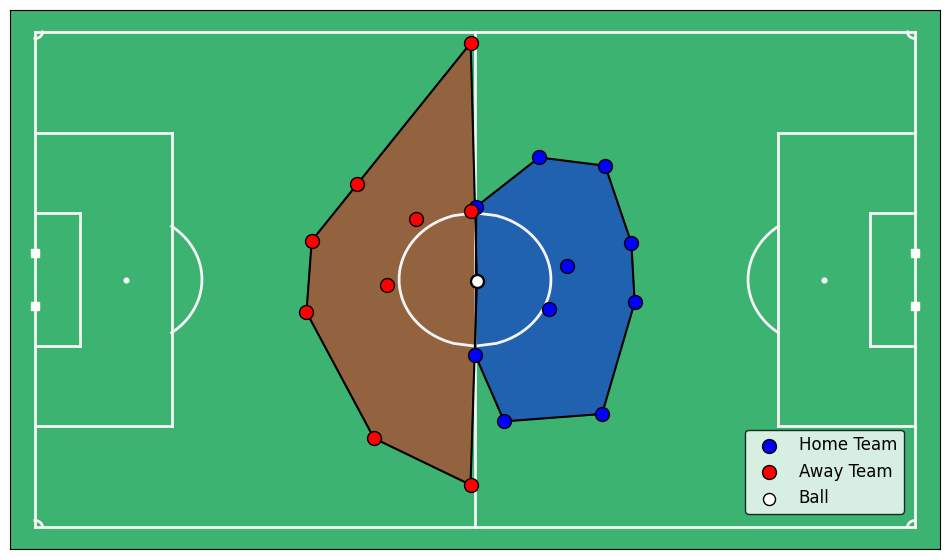

In [25]:
PlotPitch(frame=51,
          lag=51,
          home_xy=home_xy,
          away_xy=away_xy,
          plotHulls=True,
          plotAllPlayers=True,
          title="")

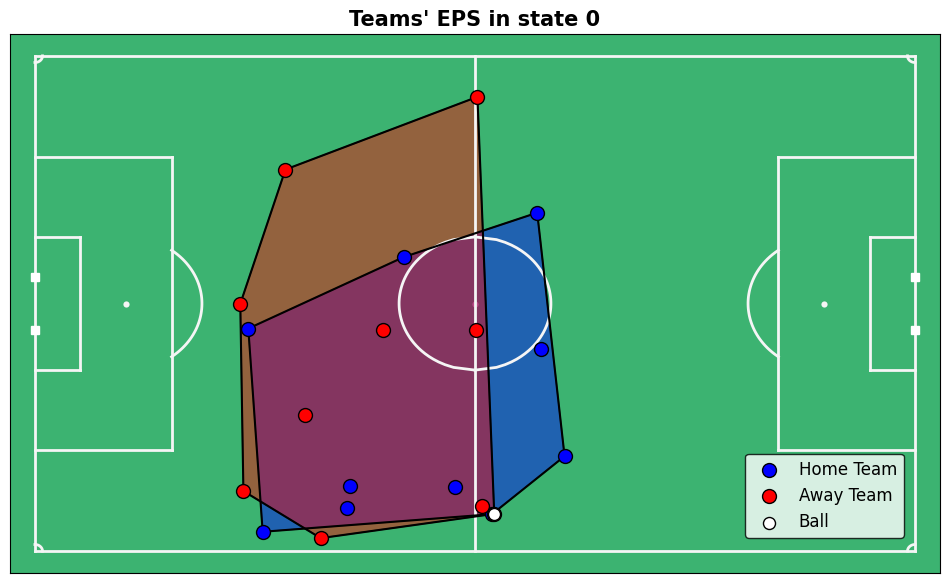

In [19]:
PlotPitch(frame=61700,
          lag=51,
          home_xy=home_xy,
          away_xy=away_xy,
          plotHulls=True,
          plotAllPlayers=True,
          title="Teams' EPS in state 0")

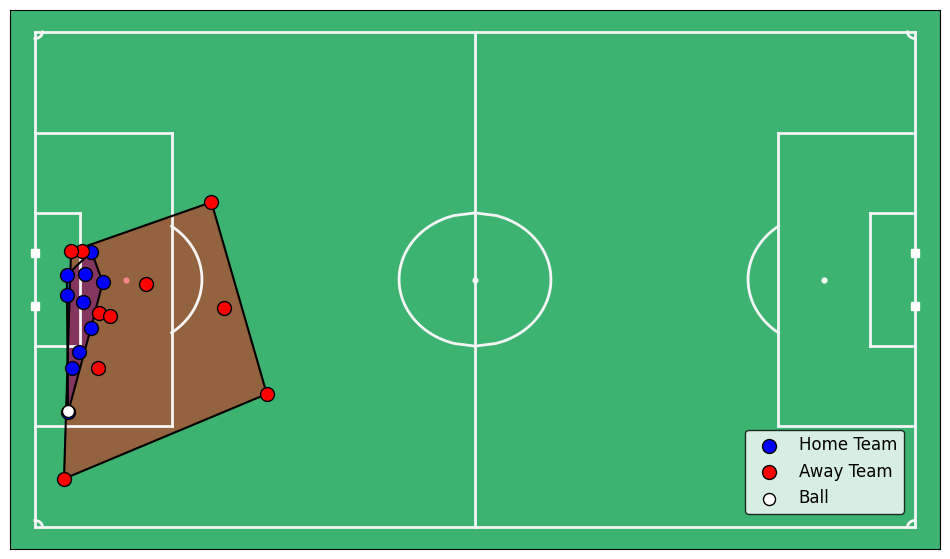

In [21]:
PlotPitch(frame=91010,
          lag=51,
          home_xy=home_xy,
          away_xy=away_xy,
          plotHulls=True,
          plotAllPlayers=True,
          title="")

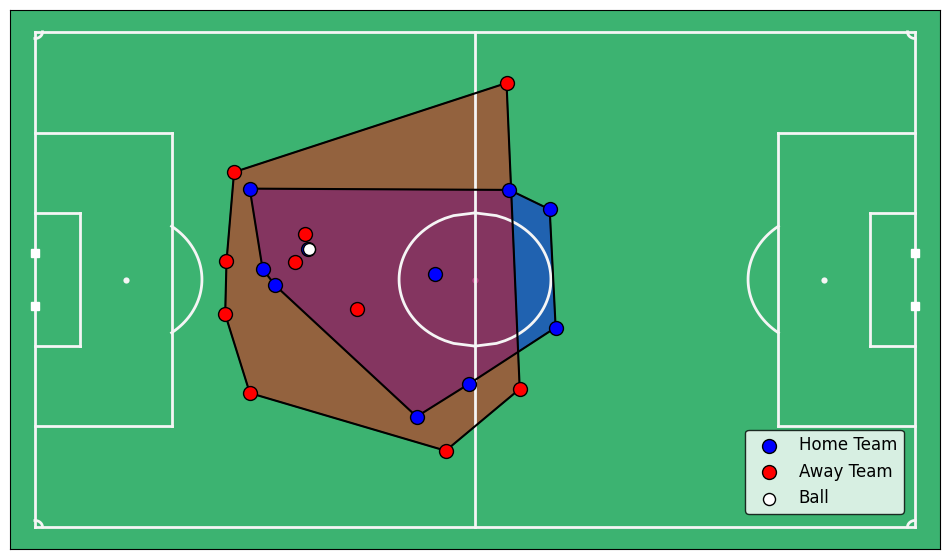

In [23]:
PlotPitch(frame=11720,
          lag=51,
          home_xy=home_xy,
          away_xy=away_xy,
          plotHulls=True,
          plotAllPlayers=True,
          title="")

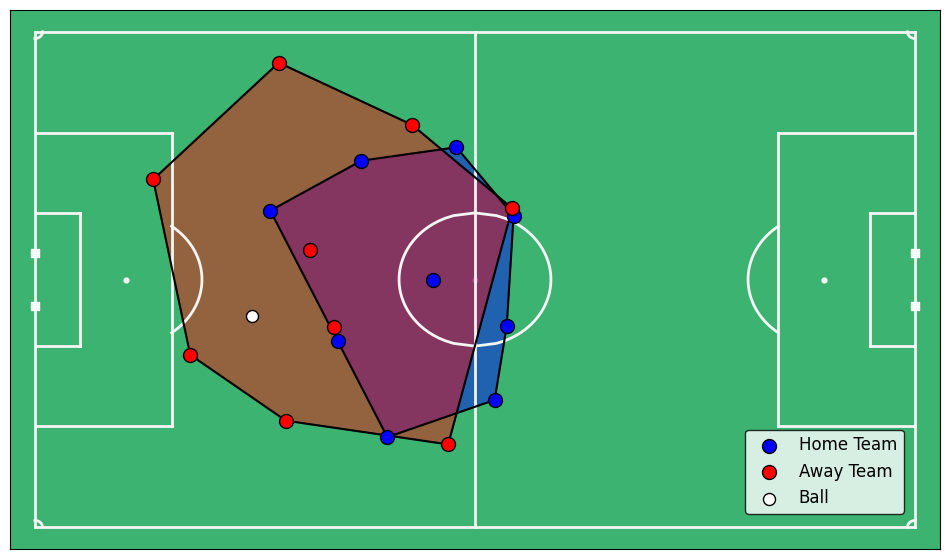

In [24]:
PlotPitch(frame=30330,
          lag=51,
          home_xy=home_xy,
          away_xy=away_xy,
          plotHulls=True,
          plotAllPlayers=True,
          title="")

# GIF

Kick off (start of the match)

In [ ]:
# PlotGIF(home_xy, away_xy, initial_frame=51,final_frame=350,lag=51,step=2,
#         gifname="gifs/plot_goal1_HomeTeam.gif",title="Kick off (start of the match)")

Goals:

In [ ]:
goals_info

NB: since the table above shows the starting frame of the goals, in the following GIFs we'll show the action from 3 seconds before (3 seconds= 75 frames before)

In [ ]:
# PlotGIF(home_xy, away_xy, initial_frame=12202-75,final_frame=12212,lag=51,step=2,
#         gifname="gifs/plot_goal1_HomeTeam.gif",title="Action leading to 1-0")

In [ ]:
# PlotGIF(home_xy, away_xy, initial_frame=53049-75,final_frame=53075,lag=51,step=2,
#         gifname="gifs/plot_goal1_AwayTeam.gif",title="Action leading to 1-1")

In [ ]:
# PlotGIF(home_xy, away_xy, initial_frame=73983-75,final_frame=73995,lag=51,step=2,
#         gifname="gifs/plot_goal2_HomeTeam.gif",title="Action leading to 2-1")

In [ ]:
# PlotGIF(home_xy, away_xy, initial_frame=115009,final_frame=115024,lag=51, step=1,
#         gifname="gifs/plot_goal2_AwayTeam.gif",title="Action leading to 2-2") #la palla è un po' sfasata sul rigore

In [ ]:
# PlotGIF(home_xy, away_xy, initial_frame=121027-75,final_frame=121055,lag=51,step=2,
#         gifname="gifs/plot_goal3_HomeTeam.gif",title="Action leading to 3-2")

## Predictions

Idea: train the model until the penalty (al momento imbrogliamo con tutto il modello) and then predict the last part of the match

**NOTE** we use 2 states as the model with 4 states will provide poor estimates to make a comparison...

In [3]:
goals_info

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
198,Home,SHOT,ON TARGET-GOAL,1,12202,488.08,12212,488.48,Player10,NaN,-47.70,-3.40,-54.06,-2.04
823,Away,SHOT,ON TARGET-GOAL,1,53049,2121.96,53075,2123.00,Player24,NaN,44.52,2.72,54.06,1.36
1118,Home,SHOT,HEAD-ON TARGET-GOAL,2,73983,2959.32,73995,2959.80,Player9,NaN,47.70,-1.36,54.06,-2.04
1671,Away,SHOT,ON TARGET-GOAL,2,115009,4600.36,115024,4600.96,Player20,NaN,-40.28,-1.36,-55.12,-2.72
1723,Home,SHOT,ON TARGET-GOAL,2,121027,4841.08,121055,4842.20,Player12,NaN,30.74,-5.44,54.06,-2.72


Predict the last part of the match:

In [4]:
data=pd.read_csv('data/hulls_df_matchday2_reduced.csv')
posterior=torch.load(f"parameters/CopulaHMM_matchday2_2states.pt")
complete_model=CopulaHMM.from_posterior(posterior)
MLS=complete_model.viterbi(torch.tensor(data[["HomeHull","AwayHull"]].values/100))
data["State"]=MLS.numpy()

Basing on the end time of the penalty, we can split our dataset into train and test

In [5]:
train_data = data[data["Time [s]"]<=4600]
test_data = data[data["Time [s]"]>4600]

In [6]:
sequence_XY = torch.tensor(train_data[["HomeHull","AwayHull"]].values/100)
PredModel= CopulaHMM(hidden_states=2)
PredModel.fit(sequence=sequence_XY,training_steps=500)

100%|██████████| 500/500 [16:29<00:00,  1.98s/it, LOSS=8.14e+3]


In [7]:
PredModel.print_estimates()

--------------------------------------------------------------------
STATE 0:
>> Mean of the Convex Hull for home team : 772.26 m^2
>> Std of the Convex Hull for home team  : 241.46 m^2
>> Mean of the Convex Hull for away team : 1195.22 m^2
>> Std of the Convex Hull for away team  : 366.59 m^2
--------------------------------------------------------------------
STATE 1:
>> Mean of the Convex Hull for home team : 1021.56 m^2
>> Std of the Convex Hull for home team  : 366.79 m^2
>> Mean of the Convex Hull for away team : 690.73 m^2
>> Std of the Convex Hull for away team  : 217.82 m^2
--------------------------------------------------------------------


In [8]:
#torch.save(PredModel.posterior, f"parameters/CopulaHMM_matchday2_2states_predict.pt")
torch.load(f"parameters/CopulaHMM_matchday2_2states_predict.pt")

Predictions:

In [24]:
pred_states, pred_areas=PredModel.predict(num_pred=test_data.shape[0],
                                          initial_state=1)

Create a dataframe compatible with the function `plotEPS_with_states` and fill its values with our predictions (both predicted states and areas)

In [25]:
pred_data = test_data.copy()
pred_data["State"]=pred_states
pred_data["HomeHull"]=pred_areas[:,0].detach().numpy()*100
pred_data["AwayHull"]=pred_areas[:,1].detach().numpy()*100

In [41]:
state_colors= {0:"#FD8033",
               1:"#0DC2B7"
               }
pred_data_plot=plotEPS_with_states(pred_data,class_colors=state_colors)
test_data_plot=plotEPS_with_states(test_data,class_colors=state_colors)

#pred_data_plot.savefig("plots/PredData_hulls.png", dpi=350, bbox_inches='tight')
#test_data_plot.savefig("plots/TestData_hulls.png", dpi=350, bbox_inches='tight')

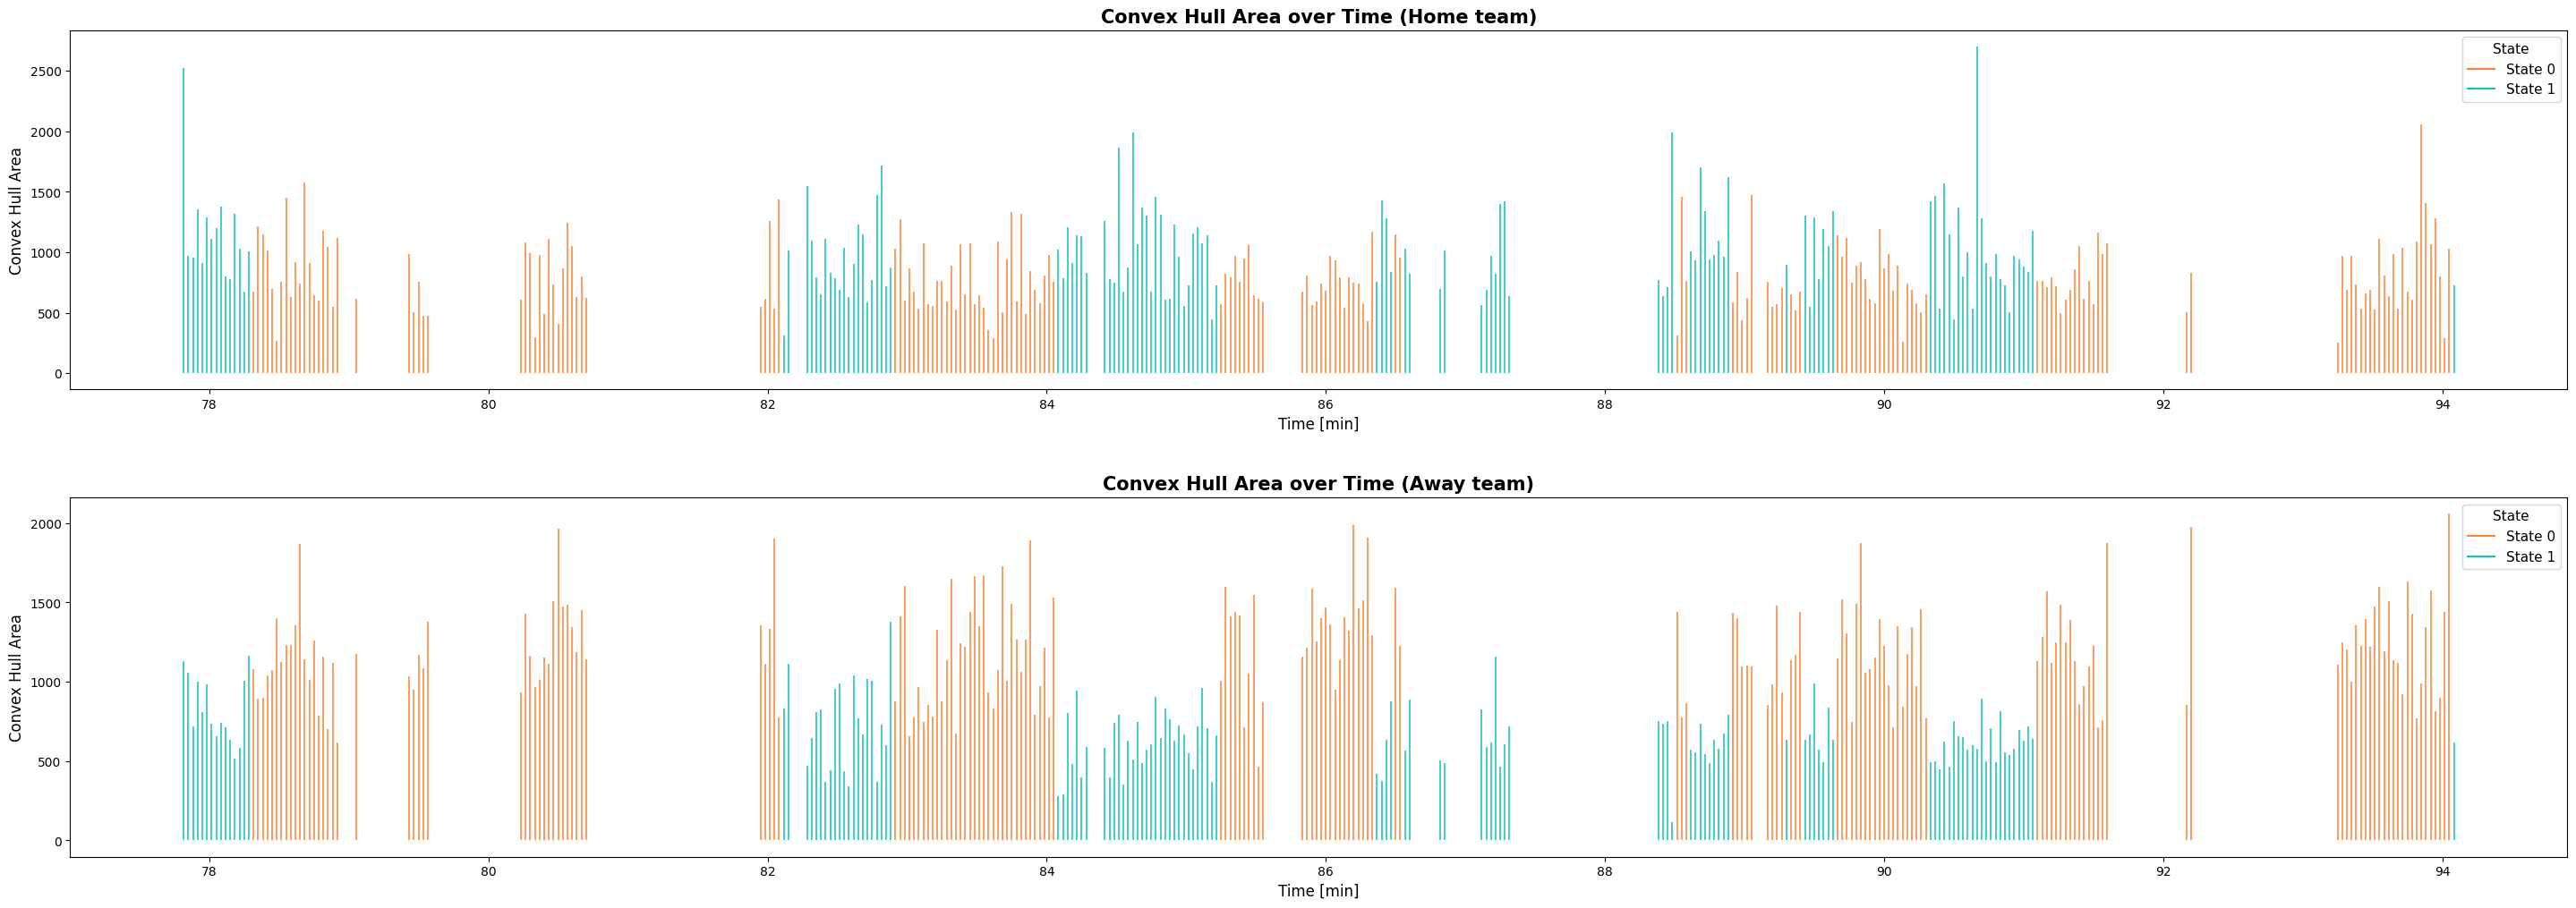

In [39]:
pred_data_plot

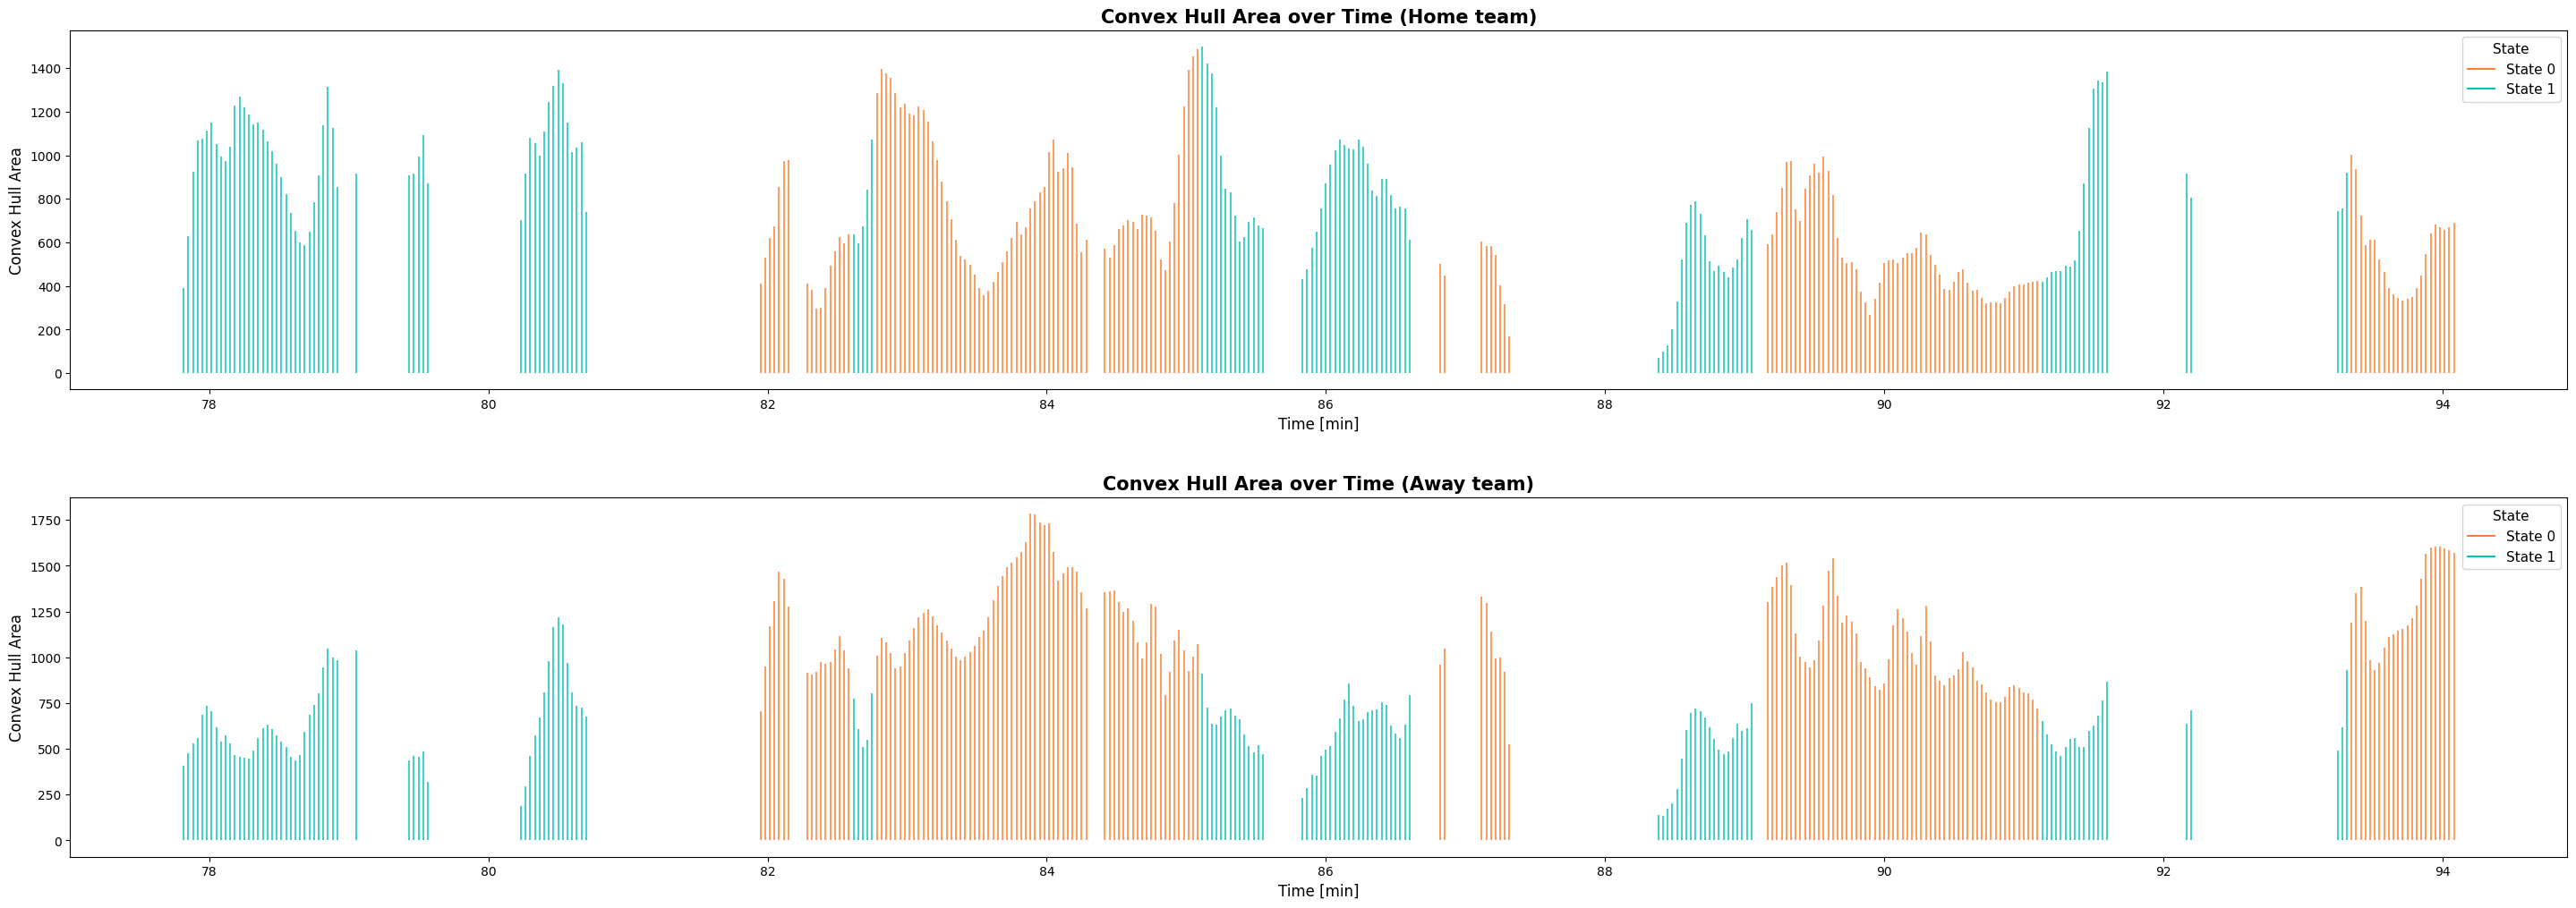

In [40]:
test_data_plot